In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [2]:
dataset = pd.read_csv('/home/jovyan/WIDE_HOME/김은선/동별_입지추천_2번.csv') #동 이름 + 동 업종별 수 + 파생 피쳐 모음

In [3]:
#정보통신업
icts = dataset.drop(['교육 서비스업', '금융 및 보험업', '도매 및 소매업', '부동산업',
       '사업시설 관리, 사업지원 및 임대 서비스업', '전문, 과학 및 기술 서비스업'], axis = 1)
icts = icts[icts['정보통신업']>5]

In [4]:
icts.index = icts['동']
icts.drop(['동'], axis = 1, inplace = True)

In [5]:
icts_scaled = pd.DataFrame(StandardScaler().fit_transform(icts), index = icts.index, columns = icts.columns)

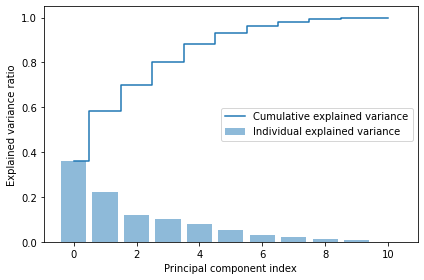

In [6]:
pca = PCA()

# # Determine transformed features # 
X_train_pca = pca.fit_transform(icts_scaled[icts_scaled.columns[:]]) 
# # Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_ 
# # Cumulative sum of eigenvalues; This will be used to create step plot # for visualizing the variance explained by each principal component. 
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# # Create the visualization plot # 
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [7]:
exp_var2 = pd.DataFrame(exp_var_pca)
cum_sum_eigenvalues2 = pd.DataFrame(cum_sum_eigenvalues)

exp_var2.columns = ['exp_var_pca']
cum_sum_eigenvalues2.columns = ['cum_sum_eigenvalues']

explainable = pd.concat([exp_var2, cum_sum_eigenvalues2], axis=1).T
explainable.columns = [i for i in range(0, len(icts_scaled.columns))]
explainable

,0,1,2,3,4,5,6,7,8,9,10
exp_var_pca,0.362505,0.221208,0.117751,0.101754,0.077326,0.051105,0.029862,0.019213,0.010871,0.007777,0.000628
cum_sum_eigenvalues,0.362505,0.583713,0.701464,0.803218,0.880544,0.931649,0.961511,0.980724,0.991595,0.999372,1.000000


In [8]:
Ex = explainable.T
appropriate_n = Ex[Ex['cum_sum_eigenvalues']>0.90].index.min() #전체 변수를 90%이상 설명할 수 있는 

In [9]:
pca = PCA(n_components = appropriate_n)
pcaed = pca.fit_transform(icts_scaled)

In [10]:
column_name = ['pca1','pca2','pca3','pca4', 'pca5']
pcaed = pd.DataFrame(pcaed, index = icts_scaled.index, columns = column_name)

In [11]:
parameter_search_DBSCAN = pd.DataFrame(columns = ['eps', 'score'], index = range(1,200))
parameter_search_KMEANS = pd.DataFrame(columns = ['n_of_cluster', 'score'], index = range(1,5))

In [12]:
for i in range(1,200): #적합한 parameter search
    eps = i/10
    model = DBSCAN(eps = eps, min_samples = 2)
    output = model.fit_predict(pcaed)
    try:
        score = silhouette_score(pcaed, output)
        parameter_search_DBSCAN['eps'][i] = eps
        parameter_search_DBSCAN['score'][i] = score
        
    except:
        parameter_search_DBSCAN['eps'][i] = eps
        parameter_search_DBSCAN['score'][i] = 0
        
for i in range(1,5):
    model = KMeans(n_clusters = i)
    output = model.fit_predict(pcaed)
    try:
        score = silhouette_score(pcaed, output)
        parameter_search_KMEANS['n_of_cluster'][i] = i
        parameter_search_KMEANS['score'][i] = score
        
    except:
        parameter_search_KMEANS['n_of_cluster'][i] = i
        parameter_search_KMEANS['score'][i] = 0

In [13]:
Optimized_DBSCAN = parameter_search_DBSCAN[parameter_search_DBSCAN['score'] == parameter_search_DBSCAN['score'].max()]
Optimized_Kmeans = parameter_search_KMEANS[parameter_search_KMEANS['score'] == parameter_search_KMEANS['score'].max()]

In [14]:
if Optimized_DBSCAN['score'].max() > Optimized_Kmeans['score'].max():
    Optimized_Model = 'DBSCAN'
    Optimized_eps = Optimized_DBSCAN['eps'].min()
    silhouette_score = Optimized_DBSCAN['score'].min()
else:
    Optimized_Model = 'KMEANS'
    Optimized_cluster = Optimized_Kmeans['n_of_cluster'].min()
    silhouette_score = Optimized_Kmeans['score'].min()
    
print('Model:', Optimized_Model)
print('eps:', Optimized_eps)
print('Score:', silhouette_score)

Model: DBSCAN
eps: 3.5
Score: 0.4134580046461787


In [15]:
model = DBSCAN(eps = Optimized_eps, min_samples = 2)
output = model.fit_predict(pcaed)

In [16]:
icts['Cluster'] = output
icts = icts[icts['Cluster'] != -1] #cluster outlier 제거

In [17]:
level_matrix_0 = icts[icts['Cluster'] ==0]
level_matrix_0.drop(['Cluster'], axis = 1, inplace = True)

In [18]:
level_scaler = MinMaxScaler()
level_scaler.fit(level_matrix_0)
level_matrix = pd.DataFrame(level_scaler.transform(level_matrix_0), index = level_matrix_0.index, columns = level_matrix_0.columns)

In [19]:
X = icts_scaled[['평당금액2', '사업체 창업률', '교통매력도', '주택매력도', '직업매력도', '총생활인구', '청소년생활인구',
       '청년생활인구', '장년생활인구', '사업체밀도']]
y =  icts_scaled['정보통신업']

regression = LinearRegression().fit(X,y)
print( "R²=", regression.score(X, y) )

Check = pd.DataFrame(columns = ['Coef'], index = ['평당금액2', '사업체 창업률', '교통매력도', '주택매력도', '직업매력도', '총생활인구', '청소년생활인구',
       '청년생활인구', '장년생활인구', '사업체밀도'])
Check['Coef'] = regression.coef_

Check = Check.T

display(Check)

R²= 0.6023413270206257


,평당금액2,사업체 창업률,교통매력도,주택매력도,직업매력도,총생활인구,청소년생활인구,청년생활인구,장년생활인구,사업체밀도
Coef,-0.167382,0.12956,-0.784949,0.246527,0.916639,0.287449,-0.070096,-0.248258,-0.22625,0.276799


In [20]:
level_1 = {'정보통신업','직업매력도'} #점수 위계
level_2 = {'총생활인구', '사업체밀도', '주택매력도'}
level_3 = {'사업체 창업률'}
level_4 = {'평당금액2', '교통매력도', '청소년생활인구', '청년생활인구', '장년생활인구'}

w_level_1 = 1 #점수가중치
w_level_2 = 0.75
w_level_3 = 0.5
w_level_4 = 0.25

final_score = 0

In [21]:
for column in level_matrix.columns:
    if column in level_1:
        final_score = final_score + level_matrix[column]*w_level_1
    elif column in level_2:
        final_score = final_score + level_matrix[column]*w_level_2
    elif column in level_3:
        final_score = final_score + level_matrix[column]*w_level_3
    elif column in level_4:
        final_score = final_score + level_matrix[column]*w_level_4
    else: print(column,'error')

In [22]:
final_score = pd.DataFrame(final_score, columns = ['Score'])
final_score.sort_values(by = 'Score', ascending = False, inplace = True)

In [23]:
TOP5_정보통신업 = final_score[:5]
TOP5_정보통신업

,Score
동,
역삼동,3.189510
서교동,2.776544
신사동,2.648200
신문로1가,2.599402
망원동,2.550455


In [62]:
# 전문, 과학 및 기술 서비스업
sp_service = dataset.drop(['정보통신업','교육 서비스업', '금융 및 보험업', '도매 및 소매업', '부동산업',
       '사업시설 관리, 사업지원 및 임대 서비스업'], axis = 1)
sp_service = sp_service[sp_service['전문, 과학 및 기술 서비스업']>5]

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [63]:
sp_service.index = sp_service['동']
sp_service.drop(['동'], axis = 1, inplace = True)

In [64]:
sp_service_scaled = pd.DataFrame(StandardScaler().fit_transform(sp_service), index = sp_service.index, columns = sp_service.columns)

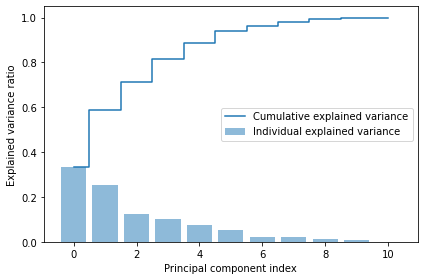

In [65]:
pca = PCA()

# # Determine transformed features # 
X_train_pca = pca.fit_transform(sp_service_scaled[sp_service_scaled.columns[:]]) 
# # Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_ 
# # Cumulative sum of eigenvalues; This will be used to create step plot # for visualizing the variance explained by each principal component. 
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# # Create the visualization plot # 
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [66]:
exp_var2 = pd.DataFrame(exp_var_pca)
cum_sum_eigenvalues2 = pd.DataFrame(cum_sum_eigenvalues)

exp_var2.columns = ['exp_var_pca']
cum_sum_eigenvalues2.columns = ['cum_sum_eigenvalues']

explainable = pd.concat([exp_var2, cum_sum_eigenvalues2], axis=1).T
explainable.columns = [i for i in range(0, len(sp_service_scaled.columns))]
explainable

,0,1,2,3,4,5,6,7,8,9,10
exp_var_pca,0.334015,0.252312,0.124895,0.102206,0.073556,0.051819,0.023175,0.019230,0.010603,0.007358,0.00083
cum_sum_eigenvalues,0.334015,0.586327,0.711222,0.813428,0.886983,0.938803,0.961978,0.981208,0.991812,0.999170,1.00000


In [67]:
Ex = explainable.T
appropriate_n = Ex[Ex['cum_sum_eigenvalues']>0.88].index.min() #전체 변수를 88%이상 설명할 수 있는 

In [68]:
pca = PCA(n_components = appropriate_n)
pcaed2 = pca.fit_transform(sp_service_scaled)

In [69]:
column_name = ['pca1','pca2','pca3','pca4']
pcaed2 = pd.DataFrame(pcaed2, index = sp_service_scaled.index, columns = column_name)

In [70]:
parameter_search_DBSCAN2 = pd.DataFrame(columns = ['eps', 'score'], index = range(1,200))
parameter_search_KMEANS2 = pd.DataFrame(columns = ['n_of_cluster', 'score'], index = range(1,5))

In [71]:
for i in range(1,200): #적합한 parameter search
    eps = i/10
    model = DBSCAN(eps = eps, min_samples = 2)
    output = model.fit_predict(pcaed2)
    try:
        score = silhouette_score(pcaed2, output)
        parameter_search_DBSCAN2['eps'][i] = eps
        parameter_search_DBSCAN2['score'][i] = score
        
    except:
        parameter_search_DBSCAN2['eps'][i] = eps
        parameter_search_DBSCAN2['score'][i] = 0
        
for i in range(1,5):
    model = KMeans(n_clusters = i)
    output = model.fit_predict(pcaed2)
    try:
        score = silhouette_score(pcaed2, output)
        parameter_search_KMEANS2['n_of_cluster'][i] = i
        parameter_search_KMEANS2['score'][i] = score
        
    except:
        parameter_search_KMEANS2['n_of_cluster'][i] = i
        parameter_search_KMEANS2['score'][i] = 0

In [72]:
Optimized_DBSCAN2 = parameter_search_DBSCAN2[parameter_search_DBSCAN2['score'] == parameter_search_DBSCAN2['score'].max()]
Optimized_Kmeans2 = parameter_search_KMEANS2[parameter_search_KMEANS2['score'] == parameter_search_KMEANS2['score'].max()]

In [74]:
if Optimized_DBSCAN2['score'].max() > Optimized_Kmeans2['score'].max():
    Optimized_Model = 'DBSCAN'
    Optimized_eps = Optimized_DBSCAN2['eps'].min()
    silhouette_score = Optimized_DBSCAN2['score'].min()
else:
    Optimized_Model = 'KMEANS'
    Optimized_cluster = Optimized_Kmeans2['n_of_cluster'].min()
    silhouette_score = Optimized_Kmeans2['score'].min()
    
print('Model:', Optimized_Model)
print('eps:', Optimized_eps)
print('Score:', silhouette_score)

Model: DBSCAN
eps: 3.2
Score: 0.43483438738505725


In [36]:
model = DBSCAN(eps = 3.2, min_samples = 2)
output = model.fit_predict(pcaed2)

In [37]:
sp_service['Cluster'] = output
sp_service = sp_service[sp_service['Cluster'] != -1] #cluster outlier 제거

In [38]:
level_matrix_1 = sp_service[sp_service['Cluster'] ==0]
level_matrix_1.drop(['Cluster'], axis = 1, inplace = True)

In [39]:
level_scaler2 = MinMaxScaler()
level_scaler2.fit(level_matrix_1)
level_matrix2 = pd.DataFrame(level_scaler2.transform(level_matrix_1), index = level_matrix_1.index, columns = level_matrix_1.columns)

In [40]:
X = sp_service_scaled[['평당금액2', '사업체 창업률', '교통매력도', '주택매력도', '직업매력도', '총생활인구', '청소년생활인구',
       '청년생활인구', '장년생활인구', '사업체밀도']]
y =  sp_service_scaled['전문, 과학 및 기술 서비스업']

regression = LinearRegression().fit(X,y)
print( "R²=", regression.score(X, y) )

Check = pd.DataFrame(columns = ['Coef'], index = ['평당금액2', '사업체 창업률', '교통매력도', '주택매력도', '직업매력도', '총생활인구', '청소년생활인구',
       '청년생활인구', '장년생활인구', '사업체밀도'])
Check['Coef'] = regression.coef_

Check = Check.T

display(Check)

R²= 0.5085870758884674


,평당금액2,사업체 창업률,교통매력도,주택매력도,직업매력도,총생활인구,청소년생활인구,청년생활인구,장년생활인구,사업체밀도
Coef,-0.13386,0.11366,-0.749973,0.276709,0.672421,-1.900583,0.313311,0.085569,1.52965,0.219686


In [41]:
level_1 = {'전문, 과학 및 기술 서비스업','장년생활인구'}
level_2 = {'직업매력도', '청소년생활인구', '주택매력도'}
level_3 = {'사업체 창업률','청년생활인구', '사업체밀도'}
level_4 = {'평당금액2','교통매력도', '총생활인구'}

w_level_1 = 1
w_level_2 = 0.75
w_level_3 = 0.5
w_level_4 = 0.25

final_score = 0

In [42]:
for column in level_matrix2.columns:
    if column in level_1:
        final_score = final_score + level_matrix2[column]*w_level_1
    elif column in level_2:
        final_score = final_score + level_matrix2[column]*w_level_2
    elif column in level_3:
        final_score = final_score + level_matrix2[column]*w_level_3
    elif column in level_4:
        final_score = final_score + level_matrix2[column]*w_level_4
    else: print(column,'error')

In [43]:
final_score = pd.DataFrame(final_score, columns = ['Score'])
final_score.sort_values(by = 'Score', ascending = False, inplace = True)

In [44]:
TOP5_전문서비스업 = final_score[:5]
TOP5_전문서비스업

,Score
동,
역삼동,3.844416
신사동,3.337607
논현동,3.117641
망원동,3.079817
서교동,2.998773
